This is the Jupyter Notebook accompanying the paper arXiv:2310.03807 (https://arxiv.org/abs/2310.03807) by Abbar & Nagakura.

# $\nu$ELN-XLN crossings

Regarding the occurence of fast flavor conversions (FFC), it's important to acknowledge that the angular distributions of $\nu_x$ and $\bar\nu_x$ can be different in CCSN and NSM environments. The $\nu$ELN-XLN function can be defined as


\begin{equation}
G(\mu) = [f_{\nu_e}(\mu) - f_{\nu_x}(\mu)] - [f_{\bar{\nu}_e}(\mu) - f_{\bar{\nu}_x}(\mu)]
\end{equation}

where $\mu = \cos\theta_\nu$ with  $\theta_\nu$ being the neutrino emission zenith angle. 


The difference between the angular distributions of $\nu_x$ and $\bar\nu_x$ becomes particularly pronounced when we account for the potential creation of muons at the core of these extreme astrophysical objects, as mentioned first in Bollig et. al. 2017.

 
The distinction between the detection of $\nu$ELN-XLN crossings and $\nu$ELN crossings presents several key differences. One of the most significant distinctions lies in the increased complexity of required information. In the context of our ML methods, this translates to an expansion in the number of essential features. Specifically, we now necessitate seven features instead of the previous three, namely $\alpha_{\nu_e}$,  $\alpha_{\nu_x}$, $\alpha_{\bar\nu_x}$, 
$F_{\nu_e}$, $F_{\bar\nu_e}$, $F_{\nu_x}$, and $F_{\bar\nu_x}$, with $\alpha_{\nu_\beta}=n_{\nu_\beta}/n_{\nu_e}$.

In this notebook, we delve into the application of machine learning to detect crossings within the most general case of the $\nu$ELN-XLN distribution. 




In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy import integrate
from scipy import special
from scipy.optimize import fsolve
import math
import random

import warnings
warnings.filterwarnings('ignore')  # Comment this to turn on warnings

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

random.seed(10)

# Producing the data using parametric angular distributions 


We here train/test our ML algorithms by
 using parametric neutrino angular distributions. The justifications for this choice are clearly explained in the paper Sec. II. A of arXiv:2303.05560.
We use two parametric neutrino angular distributions.
The first one is the maximum entropy distribution
defined as, 

\begin{equation}
f^{\rm{max-ent}}_\nu(\mu) = \frac{1}{ \exp[\eta - a\mu]},
\end{equation}

where 

\begin{equation}
 f_{\nu}(\mu) =  \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} 
        f_{\nu}(\mathbf{p}).
\end{equation}

Another angular distribution considered here is  the Gaussian distribution defined as,

\begin{equation}
f^{\rm{Gauss}}_\nu(\mu) = A\exp[-\frac{(1-\mu)^2}{a}].
\end{equation}

Note that both of these distributions have parameters which determine the overall neutrino number density, namely
$\eta$ and $A$, and the other parameter  determining the shape of the distribution, i.e., $a$.


In this study, we are interested in the following integrated quantities:

\begin{equation}
\alpha = I^{\bar\nu_e}_0/I^{\nu_e}_0,\  F_{\nu_e} = I^{\nu_e}_1/I^{\nu_e}_0,\ \mathrm{and}\ F_{\bar\nu_e} = I^{\bar\nu_e}_1/I^{\bar\nu_e}_0,
\end{equation}

which are related to the neutrino angular distributions as,

 \begin{equation}
I_n = \int_{-1}^{1} \mathrm{d}\mu\ \mu^n\ \int_0^\infty \int_0^{2\pi} \frac{E_\nu^2 \mathrm{d} E_\nu \mathrm{d} \phi_\nu}{(2\pi)^3} \
        f_{\nu}(\mathbf{p}).
\end{equation}



<br><br>

In the following cell, we develop a parent class called "**AngDist**". This class contains some general methods which perform a range of calculations for the neutrino angular distributions of any type. We have also developed two child classes, namely "*MaxentDist*" and "*GaussianDist*", which represent the maximum entropy and Gaussian angular distributions. In order to *generalize* our distributions, one can easily define the angular distribution (child) class of one's  own. 


In [174]:

class AngDist:
    """ 
    This class is the parent class of the neutrino angular distributions.
    
    ...
    
    Attributes
    ----------
    dist_type : str
        the angular distribution type (currently 'Gaussian' and 'max_ent' are included)
    args, kwargs : float
        the parameters of the angular distributions
        
    Methods
    -------
    params_setter(I_0, flux_factor):
        finds and sets the parameters of the angular distributions, given the values of the neutrino number 
        density, I0, and the flux_factor, using the internal method _params_finder(I_0, flux_factor).
    _params_finder(I_0, flux_factor):
        internal method which helps the 'params_setter' method
    check_solver():
        makes sure that the 'fsolve' has worked well enough (in the 'params_setter' method).
    _help_shape_solver(x):
        internal method which helps _params_finder solver
    _help_norm_solver(self, shape_factor, x):
        internal method which helps _params_finder solver   
    check_XLNcrossing(dist_nue, dist_nueb, dist_nux=None, dist_nuxb=None):
        checks if there is a crossing in the ELN angular distribution. Note that crossings
        are considered only if they are wider than 0.01.
    """
    
    def __init__(self, dist_type, *args, **kwargs):
        self.dist_type = dist_type
        self.args = args
        self.kwargs = kwargs
        
    def params_setter(self, I_0, flux_factor_val):
        self.args = self._params_finder(I_0, flux_factor_val)
                 
    def _params_finder(self, I_0, flux_factor_val):
        shape_factor = fsolve(lambda x: self._help_shape_solver(x) - flux_factor_val, .1)[0] # The first argument of flux_factor is arbitrary
        normalization_factor = fsolve(lambda x: self._help_norm_solver(shape_factor, x) - I_0, .1)[0]
        return normalization_factor, shape_factor

    def _help_shape_solver(self, x):
        self.args = 1., x # 1. is arbitrary here
        return self.flux_factor()

    def _help_norm_solver(self, shape_factor, x):
        self.args = x, shape_factor 
        return self.I0()
    
         
    def check_solver(self):
        _I0_ini, _F_ini = self.I0(), self.flux_factor()
        self.params_setter(_I0_ini, _F_ini)
        _I0_fin, _F_fin = self.I0(), self.flux_factor()
        difference = np.linalg.norm(np.array([_I0_fin - _I0_ini, _F_fin - _F_ini]))
        r = False
        if difference<1.e-2: r = True
        return r
 
    
    @staticmethod
    def check_ELNcrossing(dist_nue, dist_nueb, dist_nux=None, dist_nuxb=None):
        x = np.arange(-1.,1.01,.01)   # Only crossings > 0.01 are considered.
        if (not dist_nux) or (not dist_nuxb):                     
            T = np.sign(dist_nue.I0() - dist_nueb.I0()) * (dist_nue.angular_distribution(x) - dist_nueb.angular_distribution(x))
        else:
            T = np.sign(dist_nue.I0() - dist_nux.I0() - dist_nueb.I0() + dist_nuxb.I0()) * ( dist_nue.angular_distribution(x) - dist_nueb.angular_distribution(x) - dist_nux.angular_distribution(x) + dist_nuxb.angular_distribution(x) )     
        r, x_c = False, None        # x_c is the crossing angle
        if (T<0).any():
            r = True
            crossing_ind = np.where(np.diff(np.sign(T)))[0]
            x_c = x[crossing_ind]
        return r, x_c
            

            
            
            

            
class MaxentDist(AngDist):
    """ 
    The maximum entropy neutrino angular distributions with the shape 'f_nu(mu) = 1./exp(eta-a*mu)'.
    
    ...
    
    Attributes
    ----------
    args : eta, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu = cos\theta
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, eta=1, a=1):
        super().__init__('max_ent', eta, a)
            
    def angular_distribution(self, mu):
        eta , a = self.args
        return np.exp(-eta+a*mu)
        
    
    def I0(self):
        eta , a = self.args
        return 2*np.exp(-eta)*np.sinh(a)/a
      
    def flux_factor(self):
        eta , a = self.args
        return np.cosh(a)/np.sinh(a) - 1./a
    
    
    
    
    
class GaussianDist(AngDist):
    """ 
    The Gaussian neutrino angular distributions with the shape 'f_nu(mu) = A*exp( -(1-mu)**2/a )'.
    
    ...
    
    Attributes
    ----------
    args : A, a
        
    Methods
    -------
    angular_distribution(self, mu):
        the angular distribution as a function of mu
    I0(self, *args):
        the total neutrino number density, i.e., I0 = int_{-1}^{+1} f_nu(mu) d_mu 
    flux_factor(self, *args):
        the neutrino flux factor = I1/I0, where I1 = int_{-1}^{+1} mu*f_nu(mu) d_mu 
    """
    
    # Note that the second argument represents the shape (for generalization)
    def __init__(self, A=1, a=1):
        super().__init__('Gaussian', A, a)
      
    def angular_distribution(self, mu):
        A , a = self.args
        return A*np.exp( -(1-mu)**2/a ) 
     
    
    def I0(self):
        A , a = self.args
        return A*0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
    
    # See the explanation above I0(self, *args). 
    def flux_factor(self):
            A , a = self.args
            I0_ = 0.5* np.sqrt(np.pi) * np.sqrt(a) * special.erf(2/np.sqrt(a))
            I1_ = I0_ + 0.5*a* ( np.exp(-4/a) - 1 )
            return I1_/I0_
               


###  Example

Now, let's delve into an illustrative example demonstrating how to utilize these classes for generating custom distributions and evaluating XLN crossings. In this scenario, we'll create four distinct random distributions and pinpoint the XLN crossing points.


Here:


\begin{align}
\alpha &= \frac{n_{\bar\nu_e}}{n_{\nu_e}}\\
\alpha_x &= \frac{n_{\nu_x}}{n_{\nu_e}}\\
\alpha_\bar{x} &= \frac{n_{\bar\nu_x}}{n_{\nu_e}}
\end{align}



<br><br>


crossing status:  True
crossing point:  [0.15 0.62]


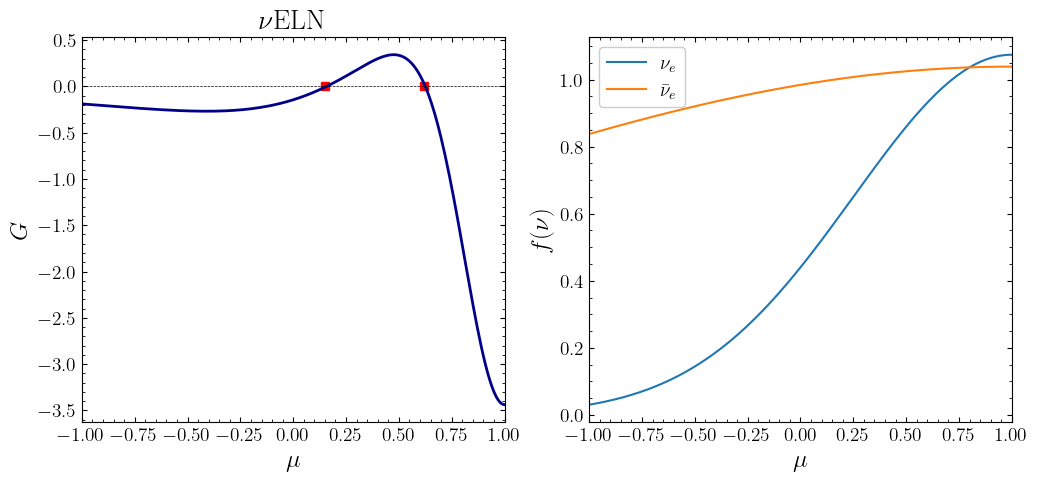

In [180]:
# alpha = n_nueb/n_nue, and F_nue and F_nueb are the flux factors of nu_e and nu_eb

alpha, alpha_x, alpha_xb, F_nue, F_nueb,  F_nux, F_nuxb = 2*random.random(), 2*random.random(), 2*random.random(), random.random(), random.random(), random.random(), random.random() 
dist_nue, dist_nueb, dist_nux, dist_nuxb = GaussianDist(), GaussianDist(), GaussianDist(), GaussianDist()
dist_nue.params_setter(1., F_nue)
dist_nueb.params_setter(alpha, F_nueb)
dist_nux.params_setter(alpha_x, F_nux)
dist_nuxb.params_setter(alpha_xb, F_nuxb)
cr, mu_c = AngDist.check_ELNcrossing(dist_nue, dist_nueb, dist_nux, dist_nuxb)
x = np.arange(-1.,1.01,.01)   
G = dist_nue.angular_distribution(x) - dist_nueb.angular_distribution(x) - dist_nux.angular_distribution(x) + dist_nuxb.angular_distribution(x) 

    
# Ploting
fig = plt.figure(figsize=(12,5))
fig.add_subplot(121)
if cr: plt.plot(mu_c,np.zeros(mu_c.size),'rs')   
plt.plot(x,G, 'darkblue', lw=2)
plt.plot(x, np.zeros(x.size),'k--', lw=.5)
plt.title(r'$\nu$ELN ', size=20)
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$G$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-1,1)

fig.add_subplot(122)
plt.plot(x,dis1.angular_distribution(x))
plt.plot(x,dis2.angular_distribution(x))
plt.xlabel(r'$\mu$',size=18)
plt.ylabel(r'$f(\nu)$',size=18)
plt.minorticks_on()
plt.tick_params(axis='y',which='both',left=True,right=True,labelleft=True, direction='in')
plt.tick_params(axis='x',which='both',top=True,bottom=True,labelbottom=True, direction='in')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend((r'$\nu_e$',r'$\bar\nu_e$'), loc = 'upper left', fontsize=14, fancybox=True, framealpha=1.)
plt.xlim(-1,1)

print('crossing status: ', cr)
print('crossing point: ',  mu_c)

## Producing the datasets
In the following cell, we produce two datasets using the Gaussian and maximum entropy angular distributions defined above.

Please note that in this context, we make the assumption that $\nu_x$ and $\bar\nu_x$ can be different, characterized by the parameter nux_coef. Additionally, we take into account the hierarchical decoupling of neutrinos, a methodology that has demonstrated its efficacy in enhancing result generalization.





<br>

In [188]:
def make_data(distribution_class, num_pnts):
    """ 
    This function generates a dataset containing a number of nu_e, nu_eb, nu_x, and nu_xb angular distributions, and 
    whether there exists a crossing for them.
        
    Parameters
    ----------
    distribution_class: python class
        the type of the neutrino angular distribution, currently MaxentDist & GaussianDist
    num_pnts: int
        the number of random points in the (F_nue, F_nueb) parameter space for each alpha
        
    Returns
    -------
    numpy array 
        of the size (num_pnts, 16) where 16 refers to [alpha, alpha_x, alpha_xb, F_nue, F_nueb, F_nux, F_nuxb, crossing, 
        (2x)prm_nue, (2x)prm_nueb, (2x)prm_nux, (2x)prm_nuxb].
    """
    
    data = np.zeros((num_pnts, 16))
    n = 0
    while n < num_pnts:
        nux_coef = np.random.uniform(-0.4,0.4)  # nux_coef determines the difference between nu_x and nu_xb
        F_nux = random.uniform(0., 1.)
        F_nuxb = F_nux + nux_coef*F_nux; F_nuxb = min(F_nuxb,1) # nu_xb can be different from nu_x by nux_coef
        F_nueb = random.uniform(0.6*min(F_nux, F_nuxb), min(F_nux, F_nuxb)) # F_nueb is smaller than F_nux(b)
        F_nue = random.uniform(0.6*F_nueb, F_nueb) # F_nue is smaller than F_nueb
        alpha = np.random.uniform(0.01,2.5)
        alpha_x = np.random.uniform(0.01,3.)
        alpha_xb = alpha_x + nux_coef*alpha_x # alpha_xb can be different from alpha_x
        
        dist_nue, dist_nueb, dist_nux, dist_nuxb = (distribution_class() for _ in range(4))
        dist_nue.params_setter(1., F_nue) # The number density of nu_e = 1 (everything is normalized by n_nue)
        dist_nueb.params_setter(alpha, F_nueb)
        dist_nux.params_setter(alpha_x, F_nux)
        dist_nuxb.params_setter(alpha_xb, F_nuxb)

        # We only count the points if the solver has done its job correctly
        if dist_nue.check_solver() and dist_nueb.check_solver() and dist_nux.check_solver() and dist_nuxb.check_solver():
            data[n, :7] = alpha, alpha_x, alpha_xb, F_nue, F_nueb, F_nux, F_nuxb
            if AngDist.check_ELNcrossing(dist_nue, dist_nueb, dist_nux, dist_nuxb)[0]: data[n, 7] = 1    # If ELN crossing is absent, it is 0
            data[n, 8:] = *dist_nue.args, *dist_nueb.args, *dist_nux.args, *dist_nuxb.args    # The parameters, e.g, a & eta
            n += 1
    return data 


# The array of alpha, and the number of random points in the (F_nue, F_nueb) parameter space 
# for which we find the angular distributions for each alpha.
NUM_PNTS = 25000


# Producing two angular distributions with the dimensions (ALPHA.size, NUM_PNTS, 8)
# This might take ~2-3 minutes
data_max_ent = make_data(MaxentDist, NUM_PNTS) 
data_gaussian= make_data(GaussianDist, NUM_PNTS)



## Data splitting

In order to train/test the ML algorithms, we split our dataset into training and test sets. Though we do not show it here, we consider anotehr independent set as our development set, to fix the hyper-parameters of the ML algorithms.

<br><br>

In [189]:
from sklearn.model_selection import train_test_split

data = np.concatenate((data_gaussian, data_max_ent), axis=0)     # combine the two data sets

X = data[:,:7]
y = data[:,7]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=10)

# ML algorithms

In this part, we show our results on detecting XLN crossings with the application of ML algorithms. We first focus on Logistic Regression (LR), which turns out to be the most promising ML algorithm to be used in detecting XLN crossings. 

In order to capture the non-linear patterns,  one should first make non-linear transformations and generate new features out of the original 7
features in  the problem. *Python sklearn* provides a module which does this, given the polynomial degree of the
nonlinear transformation, which is a hyper-parameter of this algorithm. We have fixed this parameter to be 2. 



<br><br>

## LR

In [192]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, scale


lin_mod = LogisticRegression(max_iter=100000 )

# We first make a polynomial transfomration to use the LR for a nonlinear problem
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
XX_train = poly.fit_transform(X_train); XX_test = poly.fit_transform(X_test)
# XX_train = scale(XX_train); XX_test = scale(XX_test)

lin_mod.fit(XX_train,y_train)
prediction = lin_mod.predict(XX_test)
target_names = ['no crossing', 'crossing']
score = sklearn.metrics.classification_report(y_test, prediction, target_names=target_names)
print(score)

              precision    recall  f1-score   support

 no crossing       0.87      0.89      0.88      5042
    crossing       0.88      0.86      0.87      4958

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## KNN

Though KNN is perhaps the simplest and most straightforward algorithm in many different respects, its implementation in detecting $\nu$XLN crossings in CCSN and NSM simulations may not be that efficient. This is because at any classification, one needs to load and analyze the whole training dataset, which could be computationally expensive.

We here also show how the results change once one uses cross validation. Obviously, cross validation does not affect the results since the dataset is already generic enough.

<br><br>

In [193]:
import sklearn
from sklearn import metrics, neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train,y_train)

prediction = knn.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))



# Here we comment on the idea of cross validation. 
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X, y, cv=5)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
print("cross validation scores, with n_splits=5:")
print(cross_val_score(knn, X, y, cv=cv))



              precision    recall  f1-score   support

 no crossing       0.89      0.88      0.89      5042
    crossing       0.88      0.89      0.88      4958

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

cross validation scores, with n_splits=5:
[0.8859 0.8825 0.8843 0.8842 0.8841]


## The performance of SVM \& Decision Tree Classifier

<br><br>

In [194]:
from sklearn import svm

SVM = svm.SVC(kernel='rbf', gamma=100.01)
SVM.fit(X_train,y_train)

prediction = SVM.predict(X_test)

target_names = ['no crossing', 'crossing']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 no crossing       0.92      0.84      0.88      5042
    crossing       0.85      0.93      0.89      4958

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



In [195]:
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier(class_weight={0: 2, 1: 1})
mod.fit(X_train,y_train)

prediction = mod.predict(X_test)

target_names = ['class 0', 'class 1']
print(sklearn.metrics.classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.87      0.87      0.87      5042
     class 1       0.87      0.87      0.87      4958

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

